In [22]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
# Download Data
import numpy as np
import torchvision
from torchvision import datasets

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True)

# Check the lengths of the datasets
print("Number of samples in the training set:", len(train_dataset))
print("Number of samples in the test set:", len(test_dataset))
print("")

x = train_dataset.data
y = train_dataset.targets

# Reshape and cast the input data
x = x.view(-1, 784)
x = x.to(torch.float32)

# Cast the target labels to the 'long' data type
y = y.to(torch.long)

print(f"Shape: {x.shape}")
print(f"Min: {x.min().item()}")
print(f"Max: {x.max().item()}")
print(f"Labels: {y.unique()}")
print("")

# Split data into train & valid set
from sklearn.model_selection import train_test_split

valid_pct = .2
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = valid_pct)

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)
val_labels, counts = np.unique(y_valid, return_counts=True)
print("Checking Valid Data Balance:")
for val_label, count in zip(val_labels, counts):
    print(f" Label: {val_label}, Count: {count}")


# Normalization
def min_max_scale(data, a=0, b=1):
    # Calculate the minimum and maximum values of the data
    data_min = data.min()
    data_max = data.max()

    # Perform Min-Max Scaling
    data_norm = (data - data_min) / (data_max - data_min)

    # Rescale the data to the [a, b] range
    data_norm = a + data_norm * (b - a)

    return data_norm

x_train_norm = min_max_scale(x_train)
x_valid_norm = min_max_scale(x_valid)

print("")
print(f"Train Data: {x_train_norm.shape}, Min: {x_train_norm.min()}, Max: {x_train_norm.max()}")
print(f"Valid Data: {x_valid_norm.shape}, Min: {x_valid_norm.min()}, Max: {x_valid_norm.max()}")
print("")

# Load data
from torch.utils.data import TensorDataset, DataLoader

def load_data(x_tensor, y_tensor, batch_size, test):
    data = TensorDataset(x_tensor, y_tensor)

    data_loader = DataLoader(data, batch_size=batch_size, shuffle=not test, drop_last=not test)

    print(f"Total Mini-Batches: {len(data_loader)}")
    for i, (x, y) in enumerate(data_loader):
        if i == 0:
            print(f"Shape of Each Mini-Batch: {x.shape}")
            print("")
            break
    return data_loader

batch_size = 512
train_loader = load_data(x_train, y_train, batch_size=batch_size, test = False)
valid_loader = load_data(x_valid, y_valid, batch_size=batch_size, test=True)

Number of samples in the training set: 60000
Number of samples in the test set: 10000

Shape: torch.Size([60000, 784])
Min: 0.0
Max: 255.0
Labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

torch.Size([48000, 784]) torch.Size([48000]) torch.Size([12000, 784]) torch.Size([12000])
Checking Valid Data Balance:
 Label: 0, Count: 1143
 Label: 1, Count: 1187
 Label: 2, Count: 1188
 Label: 3, Count: 1223
 Label: 4, Count: 1227
 Label: 5, Count: 1240
 Label: 6, Count: 1196
 Label: 7, Count: 1227
 Label: 8, Count: 1210
 Label: 9, Count: 1159

Train Data: torch.Size([48000, 784]), Min: 0.0, Max: 1.0
Valid Data: torch.Size([12000, 784]), Min: 0.0, Max: 1.0

Total Mini-Batches: 93
Shape of Each Mini-Batch: torch.Size([512, 784])

Total Mini-Batches: 24
Shape of Each Mini-Batch: torch.Size([512, 784])



In [24]:
def train_model(train_loader, valid_loader, loss_fn, optimizer_algorithm, lr, n_epochs, device):
    # Initialize weights and bias
    weight = torch.randn(784, 10, requires_grad=True)
    bias = torch.zeros(10, requires_grad=True)



    # Get the optimizer function based on the provided algorithm name
    opt_fn = getattr(torch.optim, optimizer_algorithm)
    optimizer = opt_fn([weight, bias], lr=lr)

    weight = weight.to(device)
    bias = bias.to(device)

    # Lists to store losses and training accuracy
    losses = torch.zeros(n_epochs, len(train_loader))
    train_acc = torch.zeros(n_epochs, len(train_loader))
    valid_acc = torch.zeros(n_epochs, len(valid_loader))

    for epoch in range(n_epochs):
        for i, (x, y) in enumerate(train_loader):
            # Convert x, y to GPU
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            out = x @ weight + bias

            # Calculate loss
            loss = loss_fn(out, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Store the loss
            losses[epoch, i] = loss.item()

            # Calculate training accuracy
            acc = 100 * (out.argmax(1) == y).float().mean()
            train_acc[epoch, i] = acc

            # Evaluation in test data
            with torch.no_grad():
                for i, (x, y) in enumerate(valid_loader):
                    # Convert x, y to GPU
                    x = x.to(device)
                    y = y.to(device)

                    out = x @ weight + bias

                    acc = 100 * (out.argmax(1) == y).float().mean()
                    valid_acc[epoch, i] = acc

    return [weight.cpu(), bias.cpu()], losses, train_acc, valid_acc

In [25]:
import torch.nn as nn

# Define the loss function (CrossEntropyLoss) and optimizer algorithm (Adam)
loss_fn = nn.CrossEntropyLoss()
optimizer_algorithm = "Adam"

# Set the learning rate and number of training epochs
learning_rate = 0.01
n_epochs = 2

%time parameters, losses, train_acc, valid_acc = train_model(train_loader, valid_loader, loss_fn, optimizer_algorithm, learning_rate, n_epochs, device)

CPU times: user 20.8 s, sys: 61.7 ms, total: 20.9 s
Wall time: 20.9 s


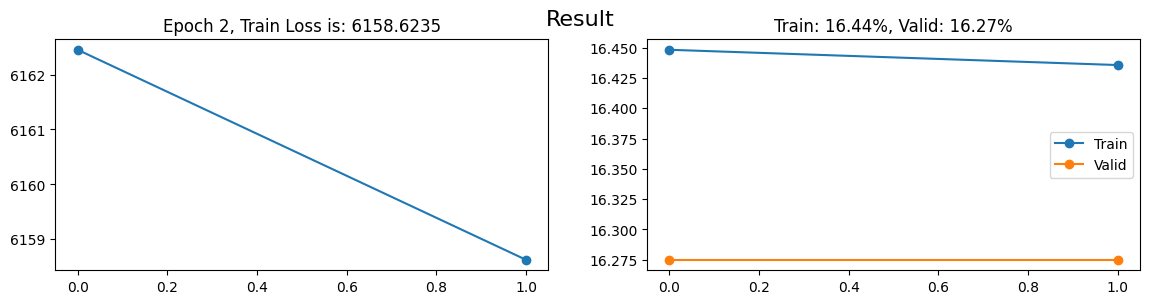

In [29]:
import matplotlib.pyplot as plt

final_loss = losses.mean(1)[-1]
final_train_acc = train_acc.mean(1)[-1]
final_valid_acc = valid_acc.mean(1)[-1]

fig, axs = plt.subplots(1, 2, figsize = (14, 3))

axs[0].plot(range(losses.shape[0]), losses.mean(1), "-o")
axs[0].set_title(f"Epoch {n_epochs}, Train Loss is: {final_loss:.4f}")


axs[1].plot(range(train_acc.shape[0]), train_acc.mean(1), "-o")
axs[1].plot(range(valid_acc.shape[0]), valid_acc.mean(1), "-o")
axs[1].set_title(f"Train: {final_train_acc:.2f}%, Valid: {final_valid_acc:.2f}%")
axs[1].legend(["Train", "Valid"])

plt.suptitle("Result", fontsize = 16)
plt.show()

In [30]:
weight = parameters[0]
bias = parameters[1]

out = x_valid @ weight + bias

ids_error = (out.argmax(1) != y_valid).nonzero()
print(f"In {len(y_valid)} images, model guess wrong {len(ids_error)}")
print(f"Accuracy is: {final_valid_acc:.2f}%")

In 12000 images, model guess wrong 10049
Accuracy is: 16.27%


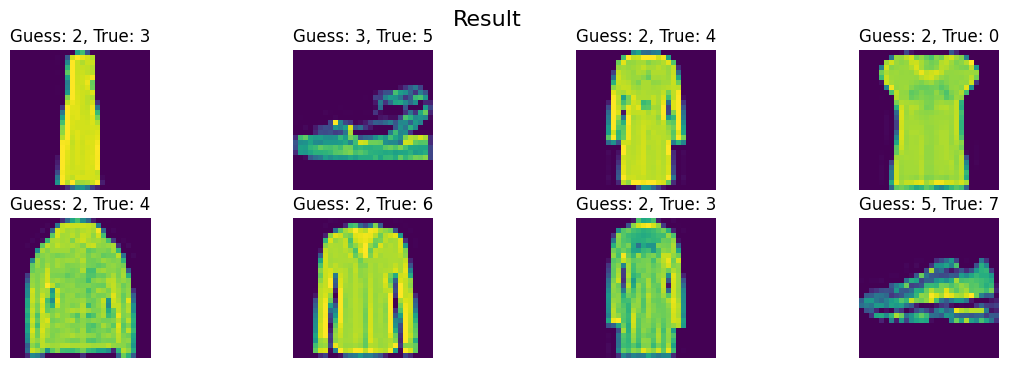

In [31]:
fig, axs = plt.subplots(2, 4, figsize=(14, 4))

for ax in axs.flatten():
    # Select a random index from the output
    random_index = np.random.choice(len(out))

    # Display the image at the selected index with colormap gray for correct predictions
    true_label = y_valid[random_index]
    guess_label = out.argmax(1)[random_index]

    if true_label == guess_label:
        ax.imshow(x_valid[random_index].view(28, 28), cmap="gray")
    else:
        ax.imshow(x_valid[random_index].view(28, 28))


    ax.set_title(f"Guess: {guess_label}, True: {true_label}")
    ax.axis("off")

plt.suptitle("Result", fontsize=16)
plt.show()